# Submit Predictions

This notebook shows how to prepare a submission of your model's predictions on the test data for the computation.

In [2]:
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from pathlib import Path
from natsort import natsorted
import numpy as np
from safetensors.torch import load_model
import torch 
import pandas as pd

from utils import hvatnet
from utils.creating_dataset import LEFT_TO_RIGHT_HAND


## Load pre-trained model

This code loads the pre-trained baseline model - might be different for your model.

In [3]:
device = 'cuda:0'
dtype = torch.float32

weights = r"/disk/scratch2/nkudryas/BAND-torch/BCI_ALVI_challenge/tutorials/logs/test_2_run_fedya/step_5250_loss_0.2735.safetensors"

MODEL_TYPE = 'hvatnet'
model_config = hvatnet.Config(n_electrodes=8, n_channels_out=20,
                            n_res_blocks=3, n_blocks_per_layer=3,
                            n_filters=128, kernel_size=3,
                            strides=(2, 2, 2), dilation=2, 
                            small_strides = (2, 2))
model = hvatnet.HVATNetv3(model_config)

load_model(model, weights)

model = model.to(device).to(dtype)

Number of parameters: 4210788


In [4]:
# load dataset from h5
data_path = Path(r"/disk/scratch2/nkudryas/BAND-torch/datasets/BCI_train.h5")
import h5py
with h5py.File(data_path, 'r') as f:
    X = f['valid_encod_data'][:]
    Y = f['valid_behavior'][:]

In [5]:
MSE = 0
for t in range(X.shape[0]):
    y_pred = model.inference(X[t])
    MSE += np.mean((y_pred - Y[t])**2)
print(101/MSE*0.1559)

/disk/scratch2/nkudryas/micromamba/envs/bci-kaggle/lib/python3.9/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1719512383855/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


0.11685660982658323


Matplotlib created a temporary cache directory at /tmp/matplotlib-bpmg26jd because the default path (/afs/inf.ed.ac.uk/user/n/nkudryas/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


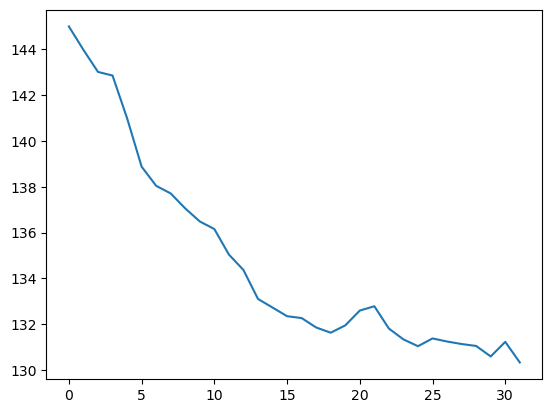

In [5]:
import matplotlib.pyplot as plt

MSE_time = np.zeros([32])
for t in range(X.shape[0]):
    y_pred = model.inference(X[t])
    MSE_time += np.mean((y_pred - Y[t])**2,axis=-1)
plt.plot(MSE_time)

In [36]:
MSE_time

array([134.74548013, 134.74548013, 134.74548013, 134.74548013,
       134.74548013, 134.74548013, 134.74548013, 134.74548013,
       134.74548013, 134.74548013, 134.74548013, 134.74548013,
       134.74548013, 134.74548013, 134.74548013, 134.74548013,
       134.74548013, 134.74548013, 134.74548013, 134.74548013,
       134.74548013, 134.74548013, 134.74548013, 134.74548013,
       134.74548013, 134.74548013, 134.74548013, 134.74548013,
       134.74548013, 134.74548013, 134.74548013, 134.74548013,
       134.74548013, 134.74548013, 134.74548013, 134.74548013,
       134.74548013, 134.74548013, 134.74548013, 134.74548013,
       134.74548013, 134.74548013, 134.74548013, 134.74548013,
       134.74548013, 134.74548013, 134.74548013, 134.74548013,
       134.74548013, 134.74548013, 134.74548013, 134.74548013,
       134.74548013, 134.74548013, 134.74548013, 134.74548013,
       134.74548013, 134.74548013, 134.74548013, 134.74548013,
       134.74548013, 134.74548013, 134.74548013, 134.74

### Save `submission.cvs` file

This code shows how the data was prepare and downsampled during inference. Make sure that your data is processed similarly!

In [5]:
DATA_PATH = Path(r"/disk/scratch_fast/nkudryas/dataset_v2_blocks")
test_data_name = 'fedya_tropin_standart_elbow_left'  # shoould match `test_dataset_list` used to train the model


data_folder = DATA_PATH / "amputant" / "left" / test_data_name / "preproc_angles" / "submit"
all_paths = natsorted(data_folder.glob('*.npz'))
print(f'Found {len(all_paths)} samples in {data_folder}')


Found 72 samples in /disk/scratch_fast/nkudryas/dataset_v2_blocks/amputant/left/fedya_tropin_standart_elbow_left/preproc_angles/submit


In [6]:

pred_list = []

# loop over each trial
for i, p in enumerate(all_paths):
    # get EMG data 
    sample = np.load(p)
    myo = sample['data_myo']
    myo = myo[:, LEFT_TO_RIGHT_HAND]

    # predictions will have to be downsampled
    gt_len = myo[::8].shape[0]

    # padding
    target_length = (myo.shape[0] + 255) // 256 * 256
    padded_myo = np.pad(myo, ((0, target_length - myo.shape[0]), (0, 0)), mode='constant', constant_values=0)

    # some prediction. might be slididng window.
    preds = model.inference(padded_myo)
    preds_downsampled = preds[:gt_len]
    print(f"Completed {i+1}/{len(all_paths)}. Loaded data: {myo.shape} - padded to: {padded_myo.shape} - predictions {preds.shape} - downsampled to: {preds_downsampled.shape}")
    pred_list.append(preds_downsampled)

pred_cat = np.concatenate(pred_list, axis=0)
df = pd.DataFrame(pred_cat)
df.head()

/disk/scratch2/nkudryas/micromamba/envs/bci-kaggle/lib/python3.9/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1719512383855/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


Completed 1/72. Loaded data: (3721, 8) - padded to: (3840, 8) - predictions (480, 20) - downsampled to: (466, 20)
Completed 2/72. Loaded data: (3725, 8) - padded to: (3840, 8) - predictions (480, 20) - downsampled to: (466, 20)
Completed 3/72. Loaded data: (3724, 8) - padded to: (3840, 8) - predictions (480, 20) - downsampled to: (466, 20)
Completed 4/72. Loaded data: (3724, 8) - padded to: (3840, 8) - predictions (480, 20) - downsampled to: (466, 20)
Completed 5/72. Loaded data: (3729, 8) - padded to: (3840, 8) - predictions (480, 20) - downsampled to: (467, 20)
Completed 6/72. Loaded data: (3726, 8) - padded to: (3840, 8) - predictions (480, 20) - downsampled to: (466, 20)
Completed 7/72. Loaded data: (3724, 8) - padded to: (3840, 8) - predictions (480, 20) - downsampled to: (466, 20)
Completed 8/72. Loaded data: (3728, 8) - padded to: (3840, 8) - predictions (480, 20) - downsampled to: (466, 20)
Completed 9/72. Loaded data: (3724, 8) - padded to: (3840, 8) - predictions (480, 20) - 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.224688,-0.032974,0.343201,0.090468,0.232570,0.002192,0.378467,0.053292,0.273059,0.008261,0.471837,0.262436,0.269101,0.013499,0.314245,0.177546,0.120567,-0.025374,0.390368,-0.077249
1,0.228221,-0.018129,0.328120,0.069635,0.237205,0.007883,0.418534,0.056629,0.301995,0.007602,0.446129,0.234545,0.289485,0.012855,0.303110,0.195419,0.149258,-0.056385,0.368347,-0.107292
2,0.263330,-0.015492,0.296143,0.057059,0.268076,0.011281,0.336451,0.022698,0.324125,0.008070,0.407882,0.214376,0.318359,0.010800,0.298510,0.194212,0.130489,-0.044943,0.343194,-0.117974
3,0.245696,-0.022762,0.313045,0.083402,0.296736,0.017667,0.351410,0.045054,0.328780,0.005911,0.360658,0.217464,0.302074,0.007850,0.339354,0.216761,0.110535,-0.028326,0.366834,-0.112463
4,0.279694,-0.030697,0.294064,0.062555,0.308046,0.015644,0.392284,0.049894,0.326741,0.006526,0.396558,0.218927,0.321763,0.009463,0.344875,0.201123,0.115177,-0.033454,0.394594,-0.107942


In addition to the predictions, your data should also include a sample id column.

In [7]:
df.insert(0, "sample_id", range(1, 1 + len(df)))

Finally, save to a CSV file. This is what you'll upload to Kaggle for the competition.

In [8]:
df.to_csv('submit_file.csv', index=False)

In [9]:
df.shape

(26829, 21)